# LSTM

First read the json files containing the news article data into a Pandas DataFrame.

In [1]:
import os
import pandas as pd

directory = 'data/jsons'

dfs = [] # an empty list to store the data frames
for f in os.listdir(directory):
    file = os.path.join(directory, f)
    data = pd.read_json(file, typ='series').to_frame().T # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs, ignore_index=True)
df

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,labor,The Week - News,1,https://theweek.com/speedreads/889936/senate-p...,Senate passes USMCA trade deal,2020-01-16,Kathryn Krawczyk,"Peacock is set to join the streaming wars , an...","Peacock is set to join the streaming wars, and...",www.theweek.com,center,KjrRi41r810ZjuCM
1,world,Reuters,1,https://www.reuters.com/article/us-g7-summit-m...,Trump puts forward own Miami-area golf course ...,2019-08-26,,"BIARRITZ , France ( ███ ) - U.S. President Don...","BIARRITZ, France (Reuters) - U.S. President Do...",www.reuters.com,center,HJyJ1GkvXaH70NL5
2,economy_and_jobs,New York Times - News,0,http://www.nytimes.com/2012/06/13/business/glo...,World Bank Warns Euro Fears May Slow Global Gr...,2012-06-13,Annie Lowrey,"Compared with other forecasters , the World Ba...","Compared with other forecasters, the World Ban...",www.nytimes.com,left,H9CkYxRYj4fgkVOt
3,politics,American Spectator,2,https://spectator.org/keep-your-hypocrisy-stai...,Keep Your Hypocrisy-Stained Hands Off Our Pres...,,"Dov Fischer, R. Emmett Tyrrell, Jeffrey Lord, ...",There is a profound difference between ( i ) t...,There is a profound difference between (i) the...,www.spectator.org,right,co0CAHsjo55yuPFa
4,national_security,Newsmax,2,https://www.newsmax.com/newsfront/jay-sekulow-...,Jay Sekulow: Mueller Tried to 'Defend the Inde...,2019-07-25,Sandy Fitzgerald,Former special counsel Robert Mueller was tryi...,Former special counsel Robert Mueller was tryi...,www.newsmax.com,right,q1CWFIi2zxqCohtv
...,...,...,...,...,...,...,...,...,...,...,...,...
37549,politics,Fox Online News,2,http://www.foxnews.com/politics/2018/03/11/war...,"Elizabeth Warren rules out presidential run, s...",2018-03-11,Joseph Weber,Massachusetts Democratic Sen. Elizabeth Warren...,Massachusetts Democratic Sen. Elizabeth Warren...,www.foxnews.com,right,GMGGdAkZAsnjxzvw
37550,abortion,Washington Times,2,http://www.washingtontimes.com/news/2015/dec/2...,Planned Parenthood hit with fetal tissue resea...,2015-12-22,"Tom Howell Jr., Valerie Richardson",An inspector general has agreed to probe how t...,An inspector general has agreed to probe how t...,www.washingtontimes.com,right,sWerDwWdOBnRBIrj
37551,elections,Reason,2,https://reason.com/blog/2019/02/10/sen-amy-klo...,Scandal-Plagued Sen. Amy Klobuchar Announces 2...,2019-02-10,"Elizabeth Nolan Brown, Nick Gillespie, J.D. Tu...",In front of a snow-drenched crowd on Boom Isla...,In front of a snow-drenched crowd on Boom Isla...,www.reason.com,right,36OUNGiMJVZRg6LN
37552,healthcare,USA TODAY,1,http://www.usatoday.com/story/news/nation/2015...,Doctors face big cuts in Medicaid pay,2015-01-04,"Phil Galewitz, Kaiser Health News","Andy Pasternak , a family doctor in Reno , saw...",CLOSE\n\nA Medicaid office employee works on r...,www.usatoday.com,center,TJygrEuycOXVfR10


For this proof of concept we are going to use the preprocessed data provided in the dataset so we can drop the unused columns.

In [2]:
df.drop(['topic', 'source', 'url', 'title', 'date', 'authors', 'content_original', 'source_url', 'bias_text', 'ID'],
        axis=1, inplace=True)
df

,bias,content
0,1,"Peacock is set to join the streaming wars , an..."
1,1,"BIARRITZ , France ( ███ ) - U.S. President Don..."
2,0,"Compared with other forecasters , the World Ba..."
3,2,There is a profound difference between ( i ) t...
4,2,Former special counsel Robert Mueller was tryi...
...,...,...
37549,2,Massachusetts Democratic Sen. Elizabeth Warren...
37550,2,An inspector general has agreed to probe how t...
37551,2,In front of a snow-drenched crowd on Boom Isla...
37552,1,"Andy Pasternak , a family doctor in Reno , saw..."


Next, remove all punctuation from the text, make all the words lowercase, remove stop words, tokenize and one-hot-encode the sentences.

In [3]:
df['content'] = df['content'].str.replace('[^\w\s]','')
df['content'] = df['content'].str.lower()

df.head()

,bias,content
0,1,peacock is set to join the streaming wars and...
1,1,biarritz france us president donald trump...
2,0,compared with other forecasters the world ban...
3,2,there is a profound difference between i the...
4,2,former special counsel robert mueller was tryi...


In [4]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [5]:
import numpy as np
'''
get average article word length to use as word count limit for LSTM, 
articles that are shorter than this will be zero-padded
Use 1/3 of this length for training time for now
'''
max_length = int(np.round(df['content'].apply(len).mean()) / 3)
max_length

1323

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

X = df['content'].to_numpy()

NUM_TOP_WORDS = None

tokenizer = Tokenizer(num_words=max_length)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = sequence.pad_sequences(sequences, maxlen=max_length)

print('Shape of data tensor:', X.shape)
print(np.max(X))

/hpc/applications/anaconda/3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/hpc/applications/anaconda/3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/hpc/applications/anaconda/3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hpc/applications/anaconda/3/lib/python3.6/site-packages/tensorf

Found 203115 unique tokens. Distilled to 203115 top words.
Shape of data tensor: (37554, 1323)
1322


Let's check the class distribution for our target variable.

In [7]:
np.unique(df['bias'].to_numpy(), return_counts=True)

(array([0, 1, 2], dtype=object), array([13005, 10815, 13734]))

As we can see they are relatively balanced so we can go ahead and split this into our train, validation, and test sets.

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

X_train, X_test, y_train, y_test = train_test_split(X, df['bias'].to_numpy(), test_size=0.1, stratify=df['bias'].to_numpy())
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1.0/9.0, stratify=y_train)

NUM_CLASSES = len(np.unique(df['bias']))
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
y_val_ohe = keras.utils.to_categorical(y_val, NUM_CLASSES)

print(len(X_train), len(X_test), len(X_val))

30042 3756 3756


With our dataset split we will now create a pre-trained embedding matrix using GloVe to be used with the LSTM.

In [9]:
%%time
EMBED_SIZE = 50

embeddings_index = {}
f = open('glove.6B.50d.txt', encoding="utf8")
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (203116, 50) 
 Total words found: 94645 
 Percentage: 46.596526123003606
CPU times: user 4.68 s, sys: 94.8 ms, total: 4.77 s
Wall time: 4.78 s


In [10]:
from tensorflow.keras.layers import Embedding

# create pre-trained embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=max_length,
                            trainable=False)

Now let's build and train the LSTM.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint

lstm = Sequential()
lstm.add(embedding_layer)
lstm.add(LSTM(300,dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(NUM_CLASSES, activation='sigmoid'))
lstm.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
lstm.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1323, 50)          10155800  
_________________________________________________________________
lstm (LSTM)                  (None, 300)               421200    
_________________________________________________________________
dense (Dense)                (None, 3)                 903       
Total params: 10,577,903
Trainable params: 422,103
Non-trainable params: 10,155,800
_________________________________________________________________


In [20]:
custom_callbacks = [
    ModelCheckpoint(
        filepath = 'best.h5',
        monitor = 'val_acc',
        mode = 'max',
        verbose = 1,
        save_best_only = True
    )
]

In [13]:
history = lstm.fit(X_train, y_train_ohe, validation_data=(X_val, y_val_ohe), 
                   epochs=10, batch_size=64, callbacks=custom_callbacks)

Train on 30042 samples, validate on 3756 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
30042/30042 [==============================] - 1618s 54ms/sample - loss: 1.0876 - acc: 0.3878 - val_loss: 1.0743 - val_acc: 0.4119
Epoch 2/10
30042/30042 [==============================] - 1596s 53ms/sample - loss: 1.0791 - acc: 0.4035 - val_loss: 1.0722 - val_acc: 0.4124
Epoch 3/10
30042/30042 [==============================] - 1620s 54ms/sample - loss: 1.0690 - acc: 0.4196 - val_loss: 1.0614 - val_acc: 0.4278
Epoch 4/10
30042/30042 [==============================] - 1624s 54ms/sample - loss: 1.0627 - acc: 0.4235 - val_loss: 1.0635 - val_acc: 0.4156
Epoch 5/10
30042/30042 [==============================] - 1621s 54ms/sample - loss: 1.0428 - acc: 0.4494 - val_loss: 1.0417 - val_acc: 0.4569
Epoch 6/10
30042/30042 [==============================] - 1625s 54ms/sample - loss: 1.0388 - acc: 0.4525 - val_loss: 0.9898 - val_acc: 0.5114
Epoch 7/10
30042/30042 [===========================

In [14]:
history.model.save('best.h5')

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt

def plotHistory(history):
    # summarize history for accuracy
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

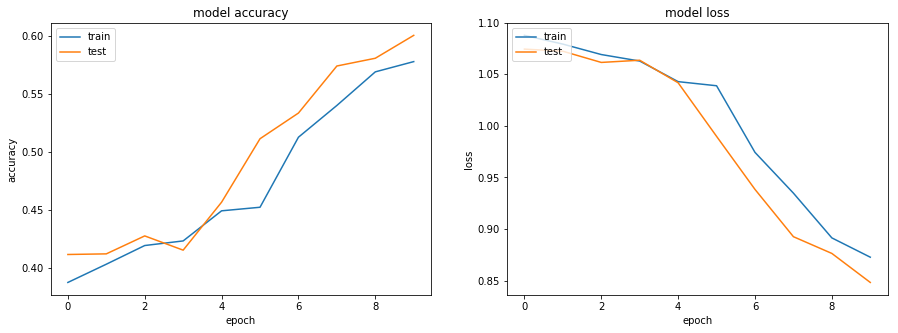

In [19]:
plotHistory(history.history)

This model has not converged yet so we can continue to train.

In [21]:
history = lstm.fit(X_train, y_train_ohe, validation_data=(X_val, y_val_ohe), 
                   epochs=10, batch_size=64, callbacks=custom_callbacks)

Train on 30042 samples, validate on 3756 samples
Epoch 1/10
30016/30042 [============================>.] - ETA: 1s - loss: 0.8478 - acc: 0.5954
Epoch 00001: val_acc improved from -inf to 0.60037, saving model to best.h5
30042/30042 [==============================] - 1619s 54ms/sample - loss: 0.8477 - acc: 0.5955 - val_loss: 0.8463 - val_acc: 0.6004
Epoch 2/10
30016/30042 [============================>.] - ETA: 1s - loss: 0.8513 - acc: 0.5919
Epoch 00002: val_acc improved from 0.60037 to 0.60410, saving model to best.h5
30042/30042 [==============================] - 1625s 54ms/sample - loss: 0.8514 - acc: 0.5917 - val_loss: 0.8410 - val_acc: 0.6041
Epoch 3/10
30016/30042 [============================>.] - ETA: 1s - loss: 0.8357 - acc: 0.6003
Epoch 00003: val_acc improved from 0.60410 to 0.60437, saving model to best.h5
30042/30042 [==============================] - 1621s 54ms/sample - loss: 0.8356 - acc: 0.6005 - val_loss: 0.8350 - val_acc: 0.6044
Epoch 4/10
30016/30042 [===============

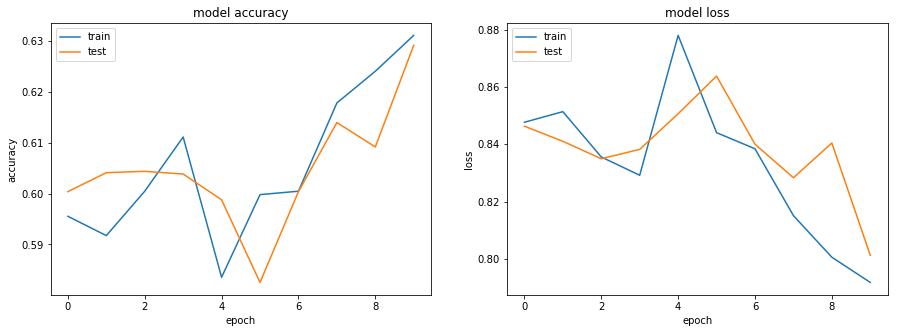

In [22]:
plotHistory(history.history)